In [19]:
import torch
loaded = torch.load("logs/2022-02-07_18:32:13")


In [20]:
from slot_attention_state_ae import DiscreteSlotAttention_model

net = DiscreteSlotAttention_model(
    n_slots=10,
    n_iters=2,
    n_attr=18,
    in_channels=3,
    encoder_hidden_channels=64,
    attention_hidden_channels=128,
    decoder_hidden_channels=64,
    decoder_initial_size=(7, 7)
)

model = torch.nn.DataParallel(net, [0])
model.load_state_dict(loaded["weights"])



<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 84, 84])


'test'

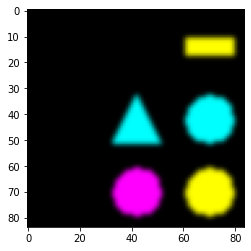

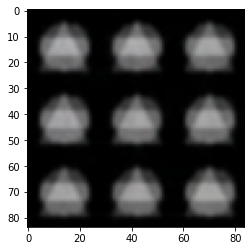

In [22]:
%matplotlib inline
from data import get_loader
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2 as cv
loader = get_loader(total_samples=2, dataset="color_shapes", deletions=5, blur=1)
iter, x = list(enumerate(loader))[0]
# x = x.to(torch.device("cuda"))
# x = x[0].permute((0,2,3,1))
model.eval()
recon_combined, recons, masks, slots = model.forward(x[0], 100)
print(x[0].shape)
plt.imshow(x[0][0].permute(1,2,0).cpu().detach().numpy())
plt.figure()
#plt.imshow(x.cpu().detach().numpy()[1])
plt.imshow(recon_combined[0].permute(1,2,0).cpu().detach().numpy())
from torchviz import make_dot
graph = make_dot(recon_combined[0])
graph.save("test")

In [24]:
model.module.slot_attention._parameters

OrderedDict([('slots_mu',
              Parameter containing:
              tensor([[[ 1.7948,  2.3593,  1.0376,  0.2504, -0.4942, -2.1553,  2.1517,
                         0.4315, -0.2461, -0.2799, -0.9673, -1.3324, -0.7142,  1.4114,
                        -0.0867,  0.2425, -0.7053, -0.3352, -0.8537, -1.2664, -1.7034,
                         0.2929,  0.0259, -0.6006,  0.4586, -1.2926,  2.0862,  1.3970,
                        -0.6252, -2.0214,  1.1044,  0.7992, -0.6815,  1.2083, -0.8276,
                         0.3002,  0.6846, -0.8975,  0.3519,  0.8478,  0.1791,  0.6760,
                        -1.3600,  1.7014,  1.0832,  0.4615,  2.3188,  0.3051,  0.5801,
                        -0.0841,  0.6752,  2.6801, -0.6005, -0.2127,  0.2822, -0.8489,
                        -0.6709, -0.1025,  0.6149,  2.3606, -0.8026, -0.0134, -0.5040,
                        -1.1859]]], device='cuda:0', requires_grad=True)),
             ('slots_log_sigma',
              Parameter containing:
           

torch.Size([3, 64, 64])


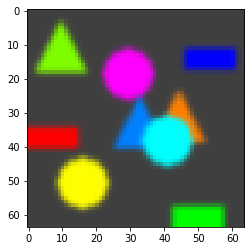

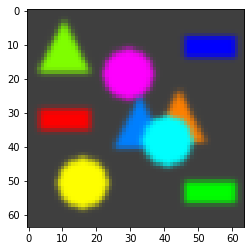

In [1]:
%matplotlib inline
from data import get_loader
import matplotlib.pyplot as plt
import torch
import numpy as np
from parameters import parameters
loader = get_loader(total_samples=2, dataset="color_shapes", deletions=parameters.deletions, image_size=parameters.image_size)
iter, x = list(enumerate(loader))[0]
print(x[0][0].shape)
plt.imshow(x[0][0].permute(1,2,0).cpu().detach().numpy())
plt.figure()
plt.imshow(x[1][0].permute(1,2,0).cpu().detach().numpy())
